In [54]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn import model_selection, preprocessing, metrics
from sklearn.utils import shuffle
import xgboost as xgb
import os
import re
import time
#import h5py
import pickle
from tqdm import tqdm
#import cv2
from keras.models import Sequential, load_model
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU
from keras.optimizers import Adam
import keras.backend.tensorflow_backend as KTF
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
color = sns.color_palette()

%matplotlib inline

In [8]:
DATA_PATH = '/kaggle/dev/carvana-image-masking-challenge-data'
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw_data')
TRAIN_PATH = os.path.join(RAW_DATA_PATH, 'train')
TEST_PATH = os.path.join(RAW_DATA_PATH, 'test')
TRAIN_MASKS_PATH = os.path.join(RAW_DATA_PATH, 'train_masks')
TRAIN_MASKS_CSV_PATH = os.path.join(RAW_DATA_PATH, 'train_masks.csv')
SAMPLE_SUBMISSION_PATH = os.path.join(RAW_DATA_PATH, 'sample_submission.csv')
METADATA_PATH = os.path.join(RAW_DATA_PATH, 'metadata.csv')

In [104]:
train_masks_df = pd.read_csv(TRAIN_MASKS_CSV_PATH)
print('train_masks_df.shape', train_masks_df.shape)
train_masks_df.head()

train_masks_df.shape (5088, 2)


,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [132]:
metadata_df = pd.read_csv(METADATA_PATH)
print('metadata_df.shape', metadata_df.shape)
metadata_df.head()

metadata_df.shape (6572, 6)


,id,year,make,model,trim1,trim2
0,0004d4463b50,2014.0,Acura,TL,TL,w/SE
1,00087a6bd4dc,2014.0,Acura,RLX,RLX,w/Tech
2,000aa097d423,2012.0,Mazda,MAZDA6,MAZDA6,i Sport
3,000f19f6e7d4,2016.0,Chevrolet,Camaro,Camaro,SS
4,00144e887ae9,2015.0,Acura,TLX,TLX,SH-AWD V6 w/Advance Pkg


In [125]:
# Verify there are 5088 train images
num_train_images = len(os.listdir(TRAIN_PATH))
print('Training set contains {} cars with {} images each'.format(int(num_train_images/16), 16))

Training set contains 318 cars with 16 images each


In [126]:
# Verify there are 100064 test images
num_train_images = len(os.listdir(TEST_PATH))
print('Test set contains {} cars with {} images each'.format(int(num_train_images/16), 16))

Test set contains 6254 cars with 16 images each


In [127]:
# Helper functions to plot car, mask, masked_car
def plot_image(img_id):
    img = mpimg.imread(os.path.join(TRAIN_PATH, img_id + ".jpg"))
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()
    
def plot_mask(img_id):
    mask = mpimg.imread(os.path.join(TRAIN_MASKS_PATH, img_id + "_mask.gif"))
    imgplot = plt.imshow(mask)
    plt.axis('off')
    plt.show()
    
def plot_masked_image(img_id):
    img = mpimg.imread(os.path.join(TRAIN_PATH, img_id + ".jpg"))
    mask = mpimg.imread(os.path.join(TRAIN_MASKS_PATH, img_id + "_mask.gif"))
    mask = mask[:,:,0:3]
    mask[mask == 255] = 1 
    masked_img = img * mask
    imgplot = plt.imshow(masked_img)
    plt.axis('off')
    plt.show()

Car id 6131a03dd028_04


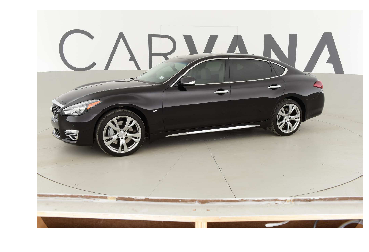

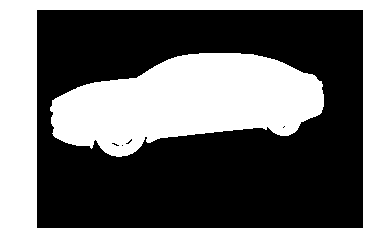

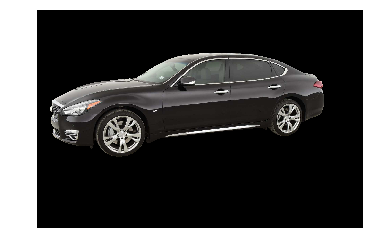

In [133]:
# Plot random car, mask, masked_car
random_car_idx = int(np.random.random() * len(train_masks_df))
random_img_path = train_masks_df.iloc[random_car_idx].values[0]
m = re.match(r'([a-f0-9].*).jpg', random_img_path)
random_img_id = m.group(1)
print('Car id {}'.format(random_img_id))
plot_image(random_img_id)
plot_mask(random_img_id)
plot_masked_image(random_img_id)

In [121]:
# Sample submission
sample_submission_df = pd.read_csv(SAMPLE_SUBMISSION_PATH)
print('sample_submission_df.shape', sample_submission_df.shape)
sample_submission_df.head()

sample_submission_df.shape (100064, 2)


,img,rle_mask
0,0004d4463b50_01.jpg,1 1
1,0004d4463b50_02.jpg,1 1
2,0004d4463b50_03.jpg,1 1
3,0004d4463b50_04.jpg,1 1
4,0004d4463b50_05.jpg,1 1
